Number of training examples: 100
Each image is of size: (64, 64, 1)
train_x_orig shape: (100, 64, 64)
train_y shape: (10, 100)
train_x's shape: (4096, 100)
Модель загружена из файла.
Number of testing examples: 1
test_x_orig shape: (1, 64, 64)
test_y shape: 1
test_x's shape: (4096, 1)
prediction:
[[1.45068841e-03]
 [1.01371455e-03]
 [1.72340023e-03]
 [9.86503230e-01]
 [5.50459618e-04]
 [2.55275285e-03]
 [8.78838488e-04]
 [7.26827647e-05]
 [4.66820654e-03]
 [5.86026668e-04]]


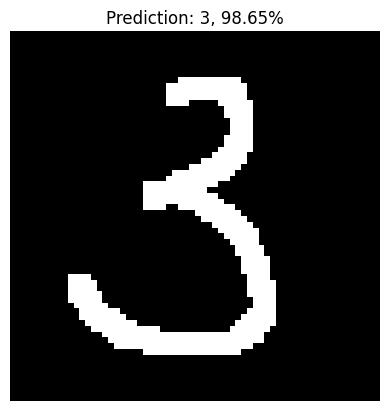

In [ ]:
# @title NeuralNetwork: "0/1/2/3/4/5/6/7/8/9 - 28x28 (old), 64x64 (new), can any size"

#********************************************** NETWORK **********************************************
#********************************************** NETWORK **********************************************
#********************************************** NETWORK **********************************************
import numpy as np


def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear(Z):
    cache = Z
    return Z, cache


def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache


def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = expZ / np.sum(expZ, axis=0, keepdims=True)
  cache = Z
  return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)
    elif activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


# Mean Square Error
def Mean_Square_Error(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cost_mse = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cost_mse + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


# Binary Cross Entropy
def Binary_Cross_Entropy(AL, Y, parameters, lambd):
    m = Y.shape[1]

    eps = 1e-10
    BCE_cost = (-1/m) * (np.dot(Y, np.log(AL + eps).T) + np.dot((1 - Y), np.log(1 - AL + eps).T))

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = BCE_cost + L2_regularization_cost
    print(cost.shape)
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


# Cross Entropy Loss
def Cross_Entropy_Loss(AL, Y, parameters, lambd):
    eps = 1e-10
    m = Y.shape[1]
    cross_entropy_cost = (-1 / m) * np.sum(Y * np.log(AL + eps))

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def compute_cost(AL, Y, parameters, lambd, function):
    if function == "MSE":
        cost = Mean_Square_Error(AL, Y, parameters, lambd)
    elif function == "BCE":
        cost = Binary_Cross_Entropy(AL, Y, parameters, lambd)
    elif function == "CEL":
        cost = Cross_Entropy_Loss(AL, Y, parameters, lambd)

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1/(1 + np.exp(-Z))

    dZ = dA*s*(1-s)
    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, activation_cache):
    # Z = activation_cache
    # s = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    # s = s / np.sum(s, axis=0, keepdims=True)
    # dZ = dA - s
    # dZ = dA
    # assert (dZ.shape == Z.shape)

    return dA


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters





#********************************************** GO USE NETWORK **********************************************
#********************************************** GO USE NETWORK **********************************************
#********************************************** GO USE NETWORK **********************************************


""" Prepare datasets for trainings and testings, functions for training, predictions, save/load model  """


# TESTING NN - "0/1/2/3/4/5/6/7/8/9 - 28x28 (old), 64x64 (new), can any size"
from PIL import Image
import os
import matplotlib.pyplot as plt


# PREPARE DATASETS FOR TRAIN
def load_training_data(base_folder):
    train_folders = [os.path.join(base_folder, f"train/{i}") for i in range(10)]

    num_px = 64
    train_images = []     # train_x
    train_labels = []     # train_y


    for i in range(10):
        for filename in os.listdir(train_folders[i]):
            image_path = os.path.join(train_folders[i], filename)
            image = Image.open(image_path).convert("L").resize([num_px, num_px], Image.LANCZOS)
            image = np.array(image)
            # Convert grayscale to black and white
            image[image < 128] = 0
            image[image >= 128] = 255
            train_images.append(image)
            train_labels.append(i)


    train_set_x_orig = np.array(train_images)
    train_set_y_orig = np.array(train_labels).reshape(1, -1)

    train_set_y_orig = np.eye(10)[train_set_y_orig.flatten()].T

    classes = np.array([str(i) for i in range(10)])




    m_train = train_set_x_orig.shape[0]

    print ("Number of training examples: " + str(m_train))
    print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 1)")
    print ("train_x_orig shape: " + str(train_set_x_orig.shape))
    print ("train_y shape: " + str(train_set_y_orig.shape))

    # Reshape the training and test examples
    train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions

    # Standardize data to have feature values between 0 and 1.
    train_x = train_x_flatten/255

    print ("train_x's shape: " + str(train_x.shape))

    return train_x, train_set_y_orig, classes



# PREPARE DATASETS FOR TEST
# in the future def Take_testing_data_from Draw_App()
def load_testing_data(base_folder):
    test_folder = os.path.join(base_folder, "test")

    num_px = 64
    test_image = []     # test_x

    for filename in os.listdir(test_folder):
        image_path = os.path.join(test_folder, filename)
        image = Image.open(image_path).convert("L").resize([num_px, num_px], Image.LANCZOS)
        image = np.array(image)
        # Convert grayscale to black and white
        image[image < 128] = 0
        image[image >= 128] = 255
        test_image.append(image)

    test_set_x_orig = np.array(test_image)



    m_test = test_set_x_orig.shape[0]

    print ("Number of testing examples: " + str(m_test))
    print ("test_x_orig shape: " + str(test_set_x_orig.shape))
    print ("test_y shape: 1")

    # Reshape the training and test examples
    test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T     # The "-1" makes reshape flatten the remaining dimensions

    # Standardize data to have feature values between 0 and 1.
    test_x = test_x_flatten/255

    print ("test_x's shape: " + str(test_x.shape))

    return test_x






# TRAINING
def training(model, X, Y, learning_rate, num_epochs, batch_size, loss_function, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd, loss_function)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters



# PREDICTION
def predict(X, parameters):
    probas, caches = L_model_forward(X, parameters)

    print("prediction:")
    print(probas)

    prediction = np.argmax(probas, axis=0)
    max_prob = np.max(probas, axis=0)
    percent = max_prob[0] * 100

    num_px = 64
    image = X[:, 0].reshape((num_px, num_px))

    # DRAW IMAGE
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {prediction[0]}, {percent:.2f}%")
    plt.axis('off')
    plt.show()
    # DRAW IMAGE








#********************************************** START MODEL **********************************************
import pickle
import os


def save_parameters(parameters, filepath):
  with open(filepath, 'wb') as file:
    pickle.dump(parameters, file)


def load_parameters(filepath):
  with open(filepath, 'rb') as file:
    return pickle.load(file)


def main():
  save_trained_parameters_file_path = '/content/drive/MyDrive/NeuralNetworks/NN_Numbers_App/model.pkl'

  datasets_folder = "/content/drive/MyDrive/NeuralNetworks/NN_Numbers_App/DatasetsNumbers_64x64"

  # LOAD TRAINING DATA
  train_x, train_y, classes = load_training_data(datasets_folder)



  # HYPERPARAMETERS
  input_neurons = 4096
  output_neurons = 10
  model = [input_neurons, 1024, output_neurons]
  learning_rate = 0.067
  num_epochs = 100
  batch_size = 32
  loss_function = "CEL"
  lambd = 0
  step__output__cost = int(num_epochs / 10)
  flag__output = True



  if os.path.exists(save_trained_parameters_file_path):
    trained_parameters = load_parameters(save_trained_parameters_file_path)
    print("Модель загружена из файла.")
  else:
    # GO TRAIN PARAMETERS
    trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, loss_function, lambd, step__output__cost, flag__output)
    save_parameters(trained_parameters, save_trained_parameters_file_path)
    print("Модель обучена и сохранена в файл.")


  # PREPARE TEST
  test_x = load_testing_data(datasets_folder)

  # GO PREDICT
  predict(test_x, trained_parameters)


main()